In [714]:
import os
import glob
import pandas as pd
from outils.conll3 import *
from collections import defaultdict, Counter
from IPython.display import HTML, display
from tqdm import tqdm
import matplotlib.pyplot as plt
import pdfkit

plt.style.use('ggplot')

path_to_wkhtmltopdf = '/usr/local/bin/wkhtmltopdf'
config = pdfkit.configuration(wkhtmltopdf=path_to_wkhtmltopdf)

In [715]:
def dico2FeatureString(dico):
    """Transforms a dictionary of Conll features into a string"""
    feature = ["=".join([key, str(dico[key])]) for key in dico]
    feature = "|".join(feature)
    return feature

def build_feature_dico(misc_features_string):
    """Turns a string of CONLL features into a callable dictionary"""
    feature_dico = {}
    for feature in misc_features_string.split("|"):
        key, value = feature.split("=")
        feature_dico[key] = value
    return feature_dico

def extract_trees_and_metadata(conll_file):
    """Extracts the trees and metadata from a CONLL file"""
    current_metadata = {}
    current_sentence = []
    sentences = []
    current_silence = []
    silences = []
    
    with open(conll_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#"):
                if "=" in line:
                    key, value = line[1:].split("=", 1)
                    current_metadata[key.strip()] = value.strip()
                else:
                    current_metadata["comments"] = current_metadata.get("comments", []) + [line[1:].strip()]
            elif line:
                token_data = line.split("\t")
                current_token = {
                    "id": int(token_data[0]),
                    "t": token_data[1],
                    "lemma": token_data[2],
                    "tag": token_data[3],
                    "xpos": token_data[4],
                    "gov": token_data[5],
                    "deprel": token_data[7],
                    "deps": token_data[8],
                    "misc": token_data[9]
                }
                if current_token['tag'] != 'PUNCT':
                    current_sentence.append(current_token)
                elif current_token['tag'] == 'PUNCT' and current_token['t'] == '#':
                    current_silence.append(current_token)
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                if current_silence:
                    silences.append(current_silence)
                    current_silence = []

    if current_sentence:
        sentences.append(current_sentence)
    if current_silence:
        silences.append(current_silence)

    return sentences, silences

In [716]:
def count_syllable_features(gold_sentences, auto_sentences):
    """Counts the syllable features in the gold and auto sentences"""
    gold_syllable_form_count = defaultdict(int)
    gold_external_onset_count = defaultdict(int)
    auto_syllable_form_count = defaultdict(int)
    auto_external_onset_count = defaultdict(int)
    gold_total_syllables = 0
    auto_total_syllables = 0

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    # GOLD
                    gold_syllables = [value for key, value in gold_feature_dico.items() if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd', 'Normalized', 'Zscore'))]
                    for syllable in gold_syllables:
                        gold_syllable_form_count[syllable] += 1
                        gold_total_syllables += 1

                    external_onsets = [key for key in gold_feature_dico if key.endswith('ExternalOnset')]
                    for onset in external_onsets:
                        gold_external_onset_count[onset] += 1

                    # AUTO
                    auto_syllables = [value for key, value in auto_feature_dico.items() if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd'))]
                    for syllable in auto_syllables:
                        auto_syllable_form_count[syllable] += 1
                        auto_total_syllables += 1

                    external_onsets = [key for key in auto_feature_dico if key.endswith('ExternalOnset')]
                    for onset in external_onsets:
                        auto_external_onset_count[onset] += 1

    combined_count = {}
    all_forms = set(gold_syllable_form_count.keys()).union(set(auto_syllable_form_count.keys()))

    for form in all_forms:
        combined_count[form] = [gold_syllable_form_count[form], auto_syllable_form_count[form]]

    df = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df = df.rename(columns={'index': 'Forme'})

    combined_onsets = {}
    all_onsets = set(gold_external_onset_count.keys()).union(set(auto_external_onset_count.keys()))
    for onset in all_onsets:
        combined_onsets[onset] = [gold_external_onset_count[onset], auto_external_onset_count[onset]]

    df_onsets = pd.DataFrame.from_dict(combined_onsets, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_onsets = df_onsets.rename(columns={'index': 'Forme'})

    return df, df_onsets, gold_total_syllables, auto_total_syllables

In [717]:
def count_mono_syllable_features(gold_sentences, auto_sentences):
    syllable_form_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    gold_total_syllables = 0
    auto_total_syllables = 0

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    # GOLD
                    if gold_feature_dico.get('SyllableCount') == '1':
                        for key, value in gold_feature_dico.items():
                            if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd', 'Normalized', 'Zscore')):
                                syllable_form_count[gold_token['t']][value]['Gold'] += 1
                                gold_total_syllables += 1

                    # AUTO
                    if auto_feature_dico.get('SyllableCount') == '1':
                        for key, value in auto_feature_dico.items():
                            if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd', 'Normalized', 'Zscore')):
                                syllable_form_count[auto_token['t']][value]['Auto'] += 1
                                auto_total_syllables += 1

    return syllable_form_count, gold_total_syllables, auto_total_syllables


In [718]:
def slam(gold_sentences, auto_sentences):
    """Counts the SLAM features in the gold and auto sentences"""
    gold_avgheightglo_count = defaultdict(int)
    gold_avgheightloc_count = defaultdict(int)
    gold_pitchrangeglo_count = defaultdict(int)
    gold_pitchrangeloc_count = defaultdict(int)
    gold_glo_count = defaultdict(int)
    gold_loc_count = defaultdict(int)

    auto_avgheightglo_count = defaultdict(int)
    auto_avgheightloc_count = defaultdict(int)
    auto_pitchrangeglo_count = defaultdict(int)
    auto_pitchrangeloc_count = defaultdict(int)
    auto_glo_count = defaultdict(int)
    auto_loc_count = defaultdict(int)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    # GOLD
                    avgheightglo = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightGlo')]
                    for height in avgheightglo:
                        gold_avgheightglo_count[height] += 1
                    
                    avgheightloc = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightLoc')]
                    for height in avgheightloc:
                        gold_avgheightloc_count[height] += 1
                    
                    pitchrangeglo = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeGlo')]
                    for pitch in pitchrangeglo:
                        gold_pitchrangeglo_count[pitch] += 1

                    pitchrangeloc = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeLoc')]
                    for pitch in pitchrangeloc:
                        gold_pitchrangeloc_count[pitch] += 1

                    glo = [value for key, value in gold_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                    for value in glo:
                        gold_glo_count[value] += 1

                    loc = [value for key, value in gold_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                    for value in loc:
                        gold_loc_count[value] += 1


                    # AUTO
                    avgheightglo = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightGlo')]
                    for height in avgheightglo:
                        auto_avgheightglo_count[height] += 1

                    avgheightloc = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightLoc')]
                    for height in avgheightloc:
                        auto_avgheightloc_count[height] += 1
                    
                    pitchrangeglo = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeGlo')]
                    for pitch in pitchrangeglo:
                        auto_pitchrangeglo_count[pitch] += 1

                    pitchrangeloc = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeLoc')]
                    for pitch in pitchrangeloc:
                        auto_pitchrangeloc_count[pitch] += 1

                    glo = [value for key, value in auto_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                    for value in glo:
                        auto_glo_count[value] += 1

                    loc = [value for key, value in auto_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                    for value in loc:
                        auto_loc_count[value] += 1

    combined_count = {}
    all_avgheightglo = set(gold_avgheightglo_count.keys()).union(set(auto_avgheightglo_count.keys()))
    all_avgheightloc = set(gold_avgheightloc_count.keys()).union(set(auto_avgheightloc_count.keys()))
    all_pitchrangeglo = set(gold_pitchrangeglo_count.keys()).union(set(auto_pitchrangeglo_count.keys()))
    all_pitchrangeloc = set(gold_pitchrangeloc_count.keys()).union(set(auto_pitchrangeloc_count.keys()))
    all_glo = set(gold_glo_count.keys()).union(set(auto_glo_count.keys()))
    all_loc = set(gold_loc_count.keys()).union(set(auto_loc_count.keys()))

    for form in all_avgheightglo:
        combined_count[form] = [gold_avgheightglo_count[form], auto_avgheightglo_count[form]]

    df_avgheightglo = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_avgheightglo = df_avgheightglo.rename(columns={'index': 'Forme'})

    for form in all_avgheightloc:
        combined_count[form] = [gold_avgheightloc_count[form], auto_avgheightloc_count[form]]

    df_avgheightloc = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_avgheightloc = df_avgheightloc.rename(columns={'index': 'Forme'})

    for form in all_pitchrangeglo:
        combined_count[form] = [gold_pitchrangeglo_count[form], auto_pitchrangeglo_count[form]]

    df_pitchrangeglo = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_pitchrangeglo = df_pitchrangeglo.rename(columns={'index': 'Forme'})

    for form in all_pitchrangeloc:
        combined_count[form] = [gold_pitchrangeloc_count[form], auto_pitchrangeloc_count[form]]
    
    df_pitchrangeloc = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_pitchrangeloc = df_pitchrangeloc.rename(columns={'index': 'Forme'})

    for form in all_glo:
        combined_count[form] = [gold_glo_count[form], auto_glo_count[form]]
                                
    df_glo = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_glo = df_glo.rename(columns={'index': 'Forme'})

    for form in all_loc:
        combined_count[form] = [gold_loc_count[form], auto_loc_count[form]]
    
    df_loc = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_loc = df_loc.rename(columns={'index': 'Forme'})


    return df_avgheightglo, df_avgheightloc, df_pitchrangeglo, df_pitchrangeloc, df_glo, df_loc

In [719]:
def slope(gold_sentences, auto_sentences):
    """Counts the slope features in the gold and auto sentences"""
    gold_slopeglo_count = defaultdict(int)
    gold_slopeloc_count = defaultdict(int)
    gold_slope_count = defaultdict(int)

    auto_slopeglo_count = defaultdict(int)
    auto_slopeloc_count = defaultdict(int)
    auto_slope_count = defaultdict(int)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    # GOLD
                    slopeglo = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeGlo')]
                    for slope in slopeglo:
                        gold_slopeglo_count[slope] += 1

                    slopeloc = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeLoc')]
                    for slope in slopeloc:
                        gold_slopeloc_count[slope] += 1

                    slope = [value for key, value in gold_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                    for value in slope:
                        gold_slope_count[value] += 1

                    # AUTO
                    slopeglo = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeGlo')]
                    for slope in slopeglo:
                        auto_slopeglo_count[slope] += 1

                    slopeloc = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeLoc')]
                    for slope in slopeloc:
                        auto_slopeloc_count[slope] += 1

                    slope = [value for key, value in auto_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                    for value in slope:
                        auto_slope_count[value] += 1

    combined_count = {}
    all_slopeglo = set(gold_slopeglo_count.keys()).union(set(auto_slopeglo_count.keys()))
    all_slopeloc = set(gold_slopeloc_count.keys()).union(set(auto_slopeloc_count.keys()))
    all_slope = set(gold_slope_count.keys()).union(set(auto_slope_count.keys()))

    for form in all_slopeglo:
        combined_count[form] = [gold_slopeglo_count[form], auto_slopeglo_count[form]]

    df_slopeglo = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_slopeglo = df_slopeglo.rename(columns={'index': 'Forme'})

    for form in all_slopeloc:
        combined_count[form] = [gold_slopeloc_count[form], auto_slopeloc_count[form]]

    df_slopeloc = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_slopeloc = df_slopeloc.rename(columns={'index': 'Forme'})

    for form in all_slope:
        combined_count[form] = [gold_slope_count[form], auto_slope_count[form]]

    df_slope = pd.DataFrame.from_dict(combined_count, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    df_slope = df_slope.rename(columns={'index': 'Forme'})

    return df_slopeglo, df_slopeloc, df_slope


In [720]:
def count_total_tokens(gold_sentences, auto_sentences):
    """Counts the total number of tokens in the gold and auto sentences"""
    total_tokens = 0
    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                total_tokens += 1
    return total_tokens

In [721]:
def count_matching_number_syllables(gold_sentences, auto_sentences):
    """Counts the number of matching syllables in the gold and auto sentences"""
    matching_syllable_count = 0
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    
                    gold_syllable_count = gold_feature_dico.get('SyllableCount')
                    # print(gold_syllable_count)
                    auto_syllable_count = auto_feature_dico.get('SyllableCount')
                    # print(auto_syllable_count)

                    if gold_syllable_count and auto_syllable_count:
                        if gold_syllable_count == auto_syllable_count:
                            matching_syllable_count += 1
                            
    results = {"MatchingSyllableCount": matching_syllable_count, "TotalTokens": total_tokens}

    return results

In [722]:
def count_matching_form_syllables(gold_sentences, auto_sentences):
    """Counts the number of matching syllable forms for each token between gold and auto sentences"""
    matching_form_syllable_count = 0
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_syllables = [value for key, value in gold_feature_dico.items() if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd', 'Normalized', 'Zscore'))]
                    auto_syllables = [value for key, value in auto_feature_dico.items() if key.startswith('Syl') and not key.endswith(('SyllableCount', 'MeanF0', 'SemitonesFromUtteranceMean', 'Semiton', 'ExternalOnset', 'Glo', 'Loc', 'Duration', 'Slope', 'SlopeGlo', 'AvgHeightGlo', 'PitchRangeGlo', 'SlopeLoc', 'AvgHeightLoc', 'PitchRangeLoc', 'MaxAmplitude', 'AvgAmplitude', 'AlignBegin', 'AlignEnd'))]

                    if gold_syllables and auto_syllables:
                        # print(gold_syllables, auto_syllables)
                        if gold_syllables == auto_syllables:
                            matching_form_syllable_count += 1
                            
    results = {"MatchingSyllableCount": matching_form_syllable_count, "TotalTokens": total_tokens}

    return results

In [723]:
def count_matching_token_alignment_features(gold_sentences, auto_sentences):
    """Counts the number of matching alignment features for each token between gold and auto sentences"""
    matching_alignment_count = 0
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_alignbegin = gold_feature_dico.get('AlignBegin')
                    gold_alignend = gold_feature_dico.get('AlignEnd')
                    auto_alignbegin = auto_feature_dico.get('AlignBegin')
                    auto_alignend = auto_feature_dico.get('AlignEnd')

                    if gold_alignbegin and gold_alignend and auto_alignbegin and auto_alignend:
                        if gold_alignbegin == auto_alignbegin and gold_alignend == auto_alignend:
                            matching_alignment_count += 1
                            
    results = {"MatchingTokenAlignmentCount": matching_alignment_count, "TotalTokens": total_tokens}

    return results

In [724]:
def count_alignment_differences(gold_sentences, auto_sentences):
    """Counts the alignment differences between gold and auto sentences"""
    intervals = range(0, 301, 10) # 0, 10, 20, 30, ..., 200
    matching_counts = {interval: 0 for interval in intervals}
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            # Ignorer les tokens de ponctuation
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_alignbegin = int(gold_feature_dico.get('AlignBegin')) if gold_feature_dico.get('AlignBegin') !=  "X" else None
                    gold_alignend = int(gold_feature_dico.get('AlignEnd')) if gold_feature_dico.get('AlignEnd')  !=  "X" else None
                    auto_alignbegin = int(auto_feature_dico.get('AlignBegin')) if auto_feature_dico.get('AlignBegin') !=  "X" else None
                    auto_alignend = int(auto_feature_dico.get('AlignEnd')) if auto_feature_dico.get('AlignEnd') !=  "X" else None

                    if gold_alignbegin is not None and gold_alignend is not None and auto_alignbegin is not None and auto_alignend is not None:
                        diff_begin = abs(gold_alignbegin - auto_alignbegin)
                        diff_end = abs(gold_alignend - auto_alignend)
                        # print(diff_begin, diff_end, gold_alignbegin, gold_alignend, auto_alignbegin, auto_alignend)
                        
                        for interval in intervals:
                            if diff_begin <= interval or diff_end <= interval:
                                matching_counts[interval] += 1
                                break

    results = {"MatchingCountsByInterval": matching_counts, "TotalTokens": total_tokens}
    return results

In [725]:
def count_matching_slam_similarity(gold_sentences, auto_sentences):
    """Counts the number of matching SLAM features for each token between gold and auto sentences"""
    matching_avgheightglo_count = 0
    matching_avgheightloc_count = 0
    matching_pitchrangeglo_count = 0
    matching_pitchrangeloc_count = 0
    matching_glo_count = 0
    matching_loc_count = 0
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_avgheightglo = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightGlo')]
                    auto_avgheightglo = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightGlo')]
                    if gold_avgheightglo and auto_avgheightglo:
                        if gold_avgheightglo == auto_avgheightglo:
                            matching_avgheightglo_count += 1

                    gold_avgheightloc = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightLoc')]
                    auto_avgheightloc = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightLoc')]
                    if gold_avgheightloc and auto_avgheightloc:
                        if gold_avgheightloc == auto_avgheightloc:
                            matching_avgheightloc_count += 1

                    gold_pitchrangeglo = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeGlo')]
                    auto_pitchrangeglo = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeGlo')]
                    if gold_pitchrangeglo and auto_pitchrangeglo:
                        if gold_pitchrangeglo == auto_pitchrangeglo:
                            matching_pitchrangeglo_count += 1

                    gold_pitchrangeloc = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeLoc')]
                    auto_pitchrangeloc = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeLoc')]
                    if gold_pitchrangeloc and auto_pitchrangeloc:
                        if gold_pitchrangeloc == auto_pitchrangeloc:
                            matching_pitchrangeloc_count += 1

                    gold_glo = [value for key, value in gold_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                    auto_glo = [value for key, value in auto_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                    if gold_glo and auto_glo:
                        if gold_glo == auto_glo:
                            matching_glo_count += 1

                    gold_loc = [value for key, value in gold_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                    auto_loc = [value for key, value in auto_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                    if gold_loc and auto_loc:
                        if gold_loc == auto_loc:
                            matching_loc_count += 1

    results = {"MatchingAvgHeightGloCount": matching_avgheightglo_count, "MatchingAvgHeightLocCount": matching_avgheightloc_count, "MatchingPitchRangeGloCount": matching_pitchrangeglo_count, "MatchingPitchRangeLocCount": matching_pitchrangeloc_count, "MatchingGloCount": matching_glo_count, "MatchingLocCount": matching_loc_count, "TotalTokens": total_tokens}

    return results

In [726]:
def count_matching_slope_similarity(gold_sentences, auto_sentences):
    """Counts the number of matching slope features for each token between gold and auto sentences"""
    matching_slopeglo_count = 0
    matching_slopeloc_count = 0
    matching_slope_count = 0
    total_tokens = count_total_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_slopeglo = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeGlo')]
                    auto_slopeglo = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeGlo')]
                    if gold_slopeglo and auto_slopeglo:
                        if gold_slopeglo == auto_slopeglo:
                            matching_slopeglo_count += 1

                    gold_slopeloc = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeLoc')]
                    auto_slopeloc = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeLoc')]
                    if gold_slopeloc and auto_slopeloc:
                        if gold_slopeloc == auto_slopeloc:
                            matching_slopeloc_count += 1

                    gold_slope = [value for key, value in gold_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                    auto_slope = [value for key, value in auto_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                    if gold_slope and auto_slope:
                        if gold_slope == auto_slope:
                            matching_slope_count += 1

    results = {"MatchingSlopeGloCount": matching_slopeglo_count, "MatchingSlopeLocCount": matching_slopeloc_count, "MatchingSlopeCount": matching_slope_count, "TotalTokens": total_tokens}

    return results

In [727]:
def calculate_percentage(part, whole):
    """Calculates the percentage of a part of a whole"""
    return round((part / whole) * 100, 2) if whole != 0 else 0

def format_count_and_percentage(count, percentage):
    """Formats a count and percentage"""
    return f"{count} ({percentage}%)"

def convert_defaultdict_to_dict(d):
    """Converts a defaultdict to a regular dictionary"""
    return dict(d)

def sum_counters(counters):
    """Sums a list of counters"""
    total = Counter()
    for counter in counters:
        total.update(counter)
    return total

In [728]:
def count_silence_tokens(gold_sentences, auto_sentences):
    """Counts the total number of silence tokens in the gold and auto sentences separately"""
    total_silence_gold = 0
    total_silence_auto = 0
    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' in gold_token['tag'] and "#" in gold_token['t']:
                total_silence_gold += 1
            if 'PUNCT' in auto_token['tag'] and "#" in auto_token['t']:
                total_silence_auto += 1
    return total_silence_gold, total_silence_auto

In [729]:
def count_matching_silence_alignment(gold_sentences, auto_sentences):
    """Counts the number of matching alignment features for silence tokens between gold and auto sentences"""
    matching_silence_alignment_count = 0
    total_silence_gold, total_silence_auto = count_silence_tokens(gold_sentences, auto_sentences)

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if ('PUNCT' in gold_token['tag'] and "#" in gold_token['t']) or ('PUNCT' in auto_token['tag'] and "#" in auto_token['t']):
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features or auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_alignbegin = gold_feature_dico.get('AlignBegin')
                    gold_alignend = gold_feature_dico.get('AlignEnd')
                    auto_alignbegin = auto_feature_dico.get('AlignBegin')
                    auto_alignend = auto_feature_dico.get('AlignEnd')

                    if gold_alignbegin or gold_alignend and auto_alignbegin or auto_alignend:
                        if gold_alignbegin == auto_alignbegin and gold_alignend == auto_alignend:
                            matching_silence_alignment_count += 1
                            
    results = {
        "MatchingSilenceAlignmentCount": matching_silence_alignment_count,
        "TotalSilenceTokensGold": total_silence_gold,
        "TotalSilenceTokensAuto": total_silence_auto
    }

    return results

In [730]:
def count_silence_alignment_duration(gold_sentences, auto_sentences):
    """Counts the alignment duration for silence tokens between gold and auto sentences"""
    intervals = range(0, 701, 10)  # 0, 10, 20, 30, ..., 300
    gold_counts = {interval: 0 for interval in intervals}
    auto_counts = {interval: 0 for interval in intervals}
    total_silence_gold, total_silence_auto = count_silence_tokens(gold_sentences, auto_sentences)


    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if "#" in gold_token['t'] or "#" in auto_token['t']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features or auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    gold_alignbegin = int(gold_feature_dico.get('AlignBegin')) if gold_feature_dico.get('AlignBegin') != "X" else None
                    gold_alignend = int(gold_feature_dico.get('AlignEnd')) if gold_feature_dico.get('AlignEnd') != "X" else None
                    auto_alignbegin = int(auto_feature_dico.get('AlignBegin')) if auto_feature_dico.get('AlignBegin') != "X" else None
                    auto_alignend = int(auto_feature_dico.get('AlignEnd')) if auto_feature_dico.get('AlignEnd') != "X" else None

                    # print("align :", gold_alignbegin, gold_alignend, auto_alignbegin, auto_alignend)

                    if gold_alignbegin is not None and gold_alignend is not None or auto_alignbegin is not None and auto_alignend is not None:
                        gold_duration = abs(gold_alignend - gold_alignbegin)
                        auto_duration = abs(auto_alignend - auto_alignbegin)
                        # print("duration :", gold_duration, auto_duration)
                        for interval in intervals:
                            if gold_duration <= interval:
                                gold_counts[interval] += 1
                                break

                            if auto_duration <= interval:
                                auto_counts[interval] += 1
                                break

    results = {
        "GoldCountsByInterval": gold_counts,
        "AutoCountsByInterval": auto_counts,
        "TotalSilenceTokensGold": total_silence_gold,
        "TotalSilenceTokensAuto": total_silence_auto
    }
    return results

In [731]:
def plot_features(df, feature_name, x_length=10):
    """Plots the features for the given dataframe"""
    # Filtrer les valeurs supérieures à 150 pour les deux colonnes
    df_filtered = df[(df['Comptage Gold'] > 150) | (df['Comptage Auto'] > 150)]
    
    df_filtered.plot(kind='bar', x='Forme', y=['Comptage Gold', 'Comptage Auto'], figsize=(x_length, 6))
    plt.title(f'{feature_name} Features (only values > 150)')
    plt.xlabel('Forme')
    plt.ylabel('Comptage')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{feature_name}_features.png')
    plt.show()

def update_global_counts(global_counts, features_df):
    """Updates the global counts with the features dataframe"""
    for key, value in features_df.iterrows():
        global_counts[value['Forme']][0] += value['Comptage Gold']
        global_counts[value['Forme']][1] += value['Comptage Auto']

def update_global_counts_mono(global_counts, features_df):
    for token, forms in features_df.items():
        if token not in global_counts:
            global_counts[token] = defaultdict(lambda: {'Gold': 0, 'Auto': 0})
        for form, counts in forms.items():
            if form not in global_counts[token]:
                global_counts[token][form] = {'Gold': 0, 'Auto': 0}
            global_counts[token][form]['Gold'] += counts['Gold']
            global_counts[token][form]['Auto'] += counts['Auto']

def convert_monosyllableform_defaultdict_to_df(nested_dict):
    data = []
    for token, forms in nested_dict.items():
        for form, counts in forms.items():
            data.append({
                'Token': token,
                'Form': form,
                'Gold Count': counts['Gold'],
                'Auto Count': counts['Auto']
            })
    return pd.DataFrame(data)

def convert_dict_to_df(global_counts):
    """Converts a dictionary to a dataframe"""
    df = pd.DataFrame.from_dict(global_counts, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    return df.rename(columns={'index': 'Forme'})

def save_html(dataframes, titles, filename):
    """Saves the dataframes as an HTML file and converts it to PDF"""
    html_content = ""
    for df, title in zip(dataframes, titles):
        html_content += f"<h2>{title}</h2>"
        html_content += df.to_html(index=False)
    
    html_filename = f"{filename}.html"
    pdf_filename = f"{filename}.pdf"

    with open(html_filename, 'w') as f:
        f.write(html_content)
    display(HTML(html_content))
    
    # Convert HTML to PDF
    # pdfkit.from_file(html_filename, pdf_filename)

In [732]:
conll_infiles = glob.glob("SUD_Naija-NSC-master/*.conllu")  # Folder containing gold CONLLU 
conll_outfolder = glob.glob("CONLL_outfiles/gold_nongold/*.conllu")  # Folder containing gold CONLLU automatically obtained 

100%|██████████| 80/80 [00:24<00:00,  3.31it/s]


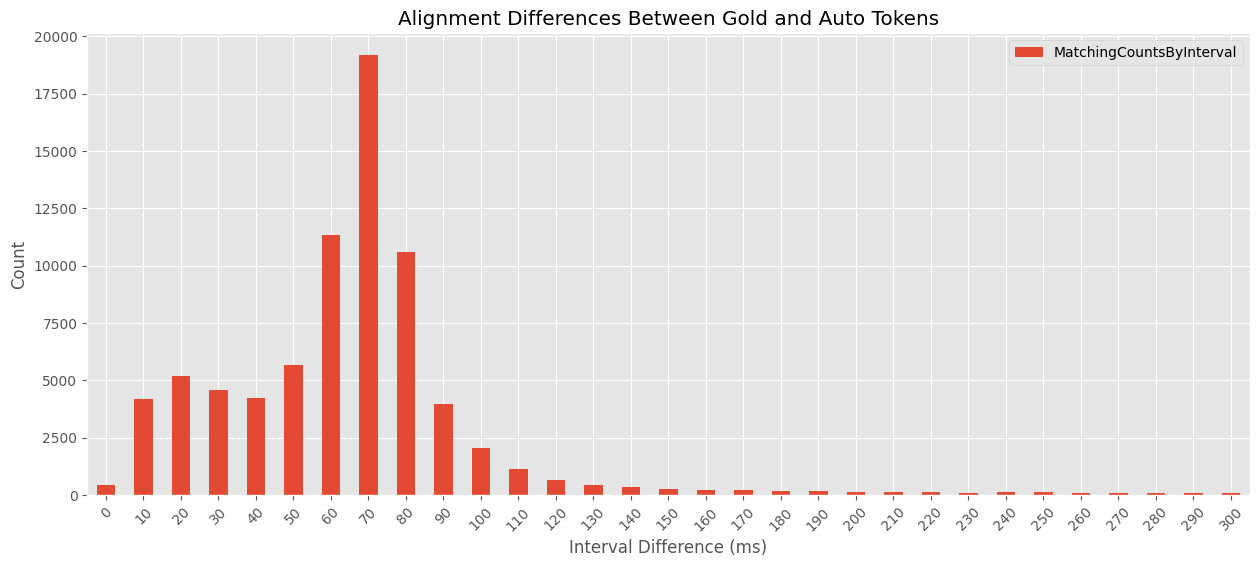

Duration,GoldCount,AutoCount
0,0,0
10,0,0
20,0,0
30,8,4
40,0,0
50,2,0
60,2,0
70,2,0
80,6,0
90,4,0


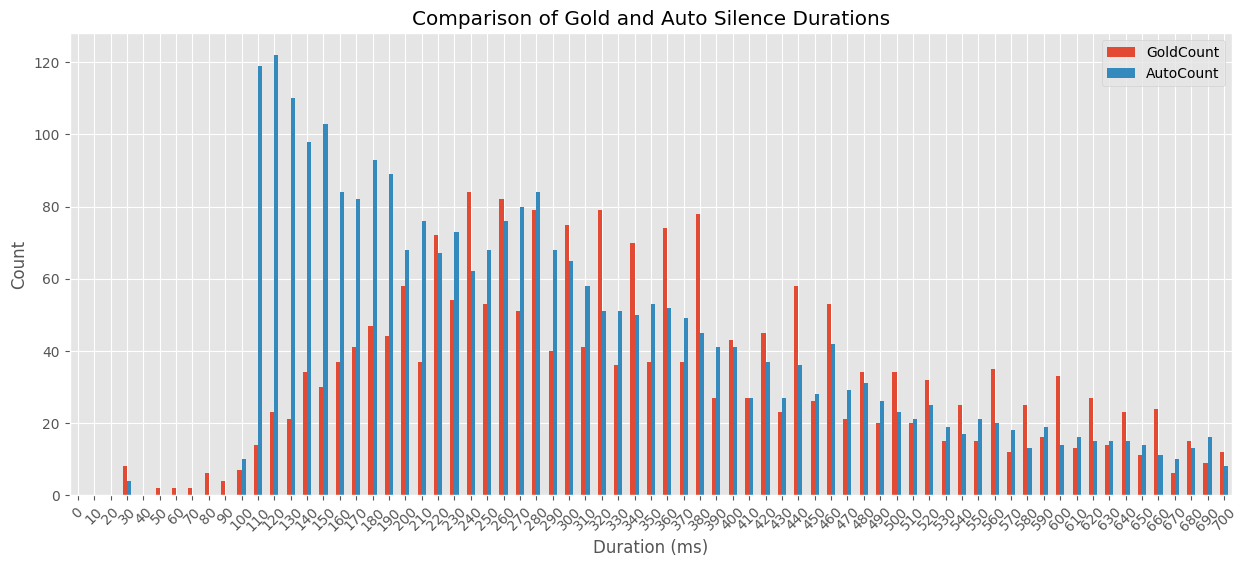

TotalMatchingSyllableCount,TotalMatchingFormSyllableCount,TotalMatchingTokenAlignmentCount,TotalMatchingAvgHeightGloCount,TotalMatchingAvgHeightLocCount,TotalMatchingPitchRangeGloCount,TotalMatchingPitchRangeLocCount,TotalMatchingGloCount,TotalMatchingLocCount,TotalMatchingSlopeGloCount,TotalMatchingSlopeLocCount,TotalMatchingSlopeCount,TotalTokens
76034 (85.83%),28918 (32.64%),3 (0.0%),53843 (60.78%),48888 (55.19%),60828 (68.66%),58937 (66.53%),37498 (42.33%),33085 (37.35%),49186 (55.52%),48513 (54.76%),44303 (50.01%),88587


IntervalDifference,MatchingCountsByInterval
0,439.0 (0.58%)
10,4168.0 (5.47%)
20,5174.0 (6.79%)
30,4562.0 (5.98%)
40,4251.0 (5.58%)
50,5674.0 (7.44%)
60,11326.0 (14.86%)
70,19182.0 (25.16%)
80,10581.0 (13.88%)
90,3966.0 (5.20%)


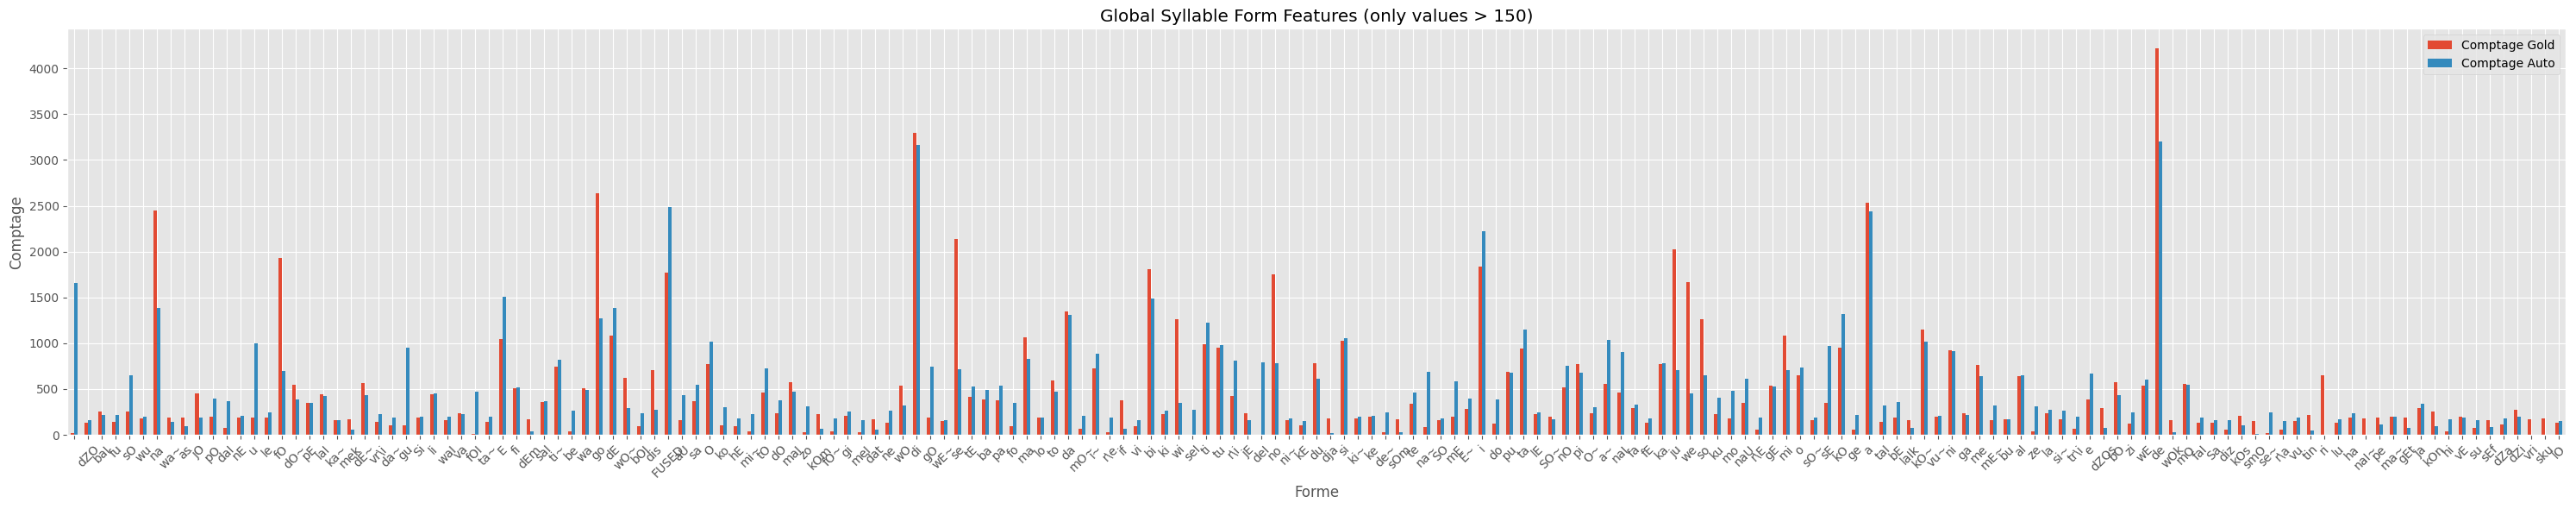

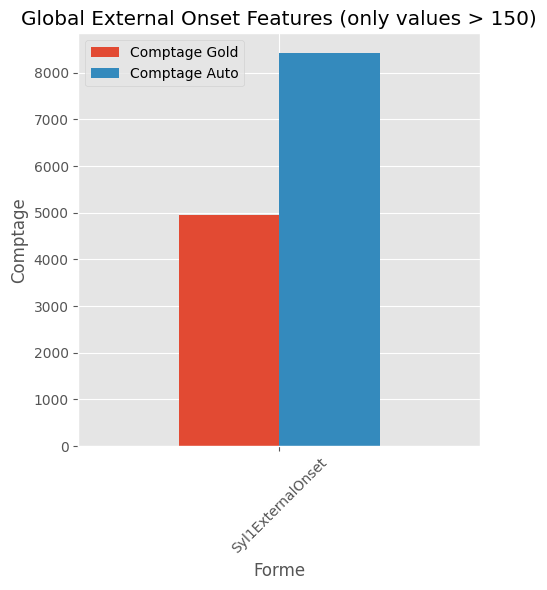

Forme,Comptage Gold,Comptage Auto
,16,1657
siv,20,8
pju,2,23
dZO,135,158
zO,17,78
bo~,10,0
gr\o,22,33
baI,255,221
pr\o,30,110
sE~,47,87


Token,Form,Gold Count,Auto Count
toh,to,10,22
toh,tO,54,27
toh,tod,0,2
toh,tow,0,2
na,na,1471,367
na,na~,11,393
na,naI,62,435
na,zE,0,1
na,ne,0,8
na,nad,1,0


/var/folders/5q/p5rcf9cs6nn2jj82d5tmjhww0000gp/T/ipykernel_78749/2718269230.py:223: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_frequent_gold = df_mono_syllable_form.groupby('Token').apply(lambda x: x.loc[x['Gold Count'].idxmax()])
/var/folders/5q/p5rcf9cs6nn2jj82d5tmjhww0000gp/T/ipykernel_78749/2718269230.py:224: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_frequent_auto = df_mono_syllable_for

Token,Form Gold,Form Gold Count Gold,Form Gold Count Auto,Form Auto,Form Auto Count Gold,Form Auto Count Auto
'll,FUSED,1,0,FUSED,1,0
'm,FUSED,11,0,E,0,1
're,FUSED,1,0,FUSED,1,0
's,FUSED,8,0,sO,0,1
A,e,4,1,eI,0,2
AC,es,1,0,e,1,2
Abi,a,0,1,a,0,1
Africa,ta,1,0,ta,1,0
All,O,1,0,r\O,0,1
Ann,a~,1,1,a~,1,1


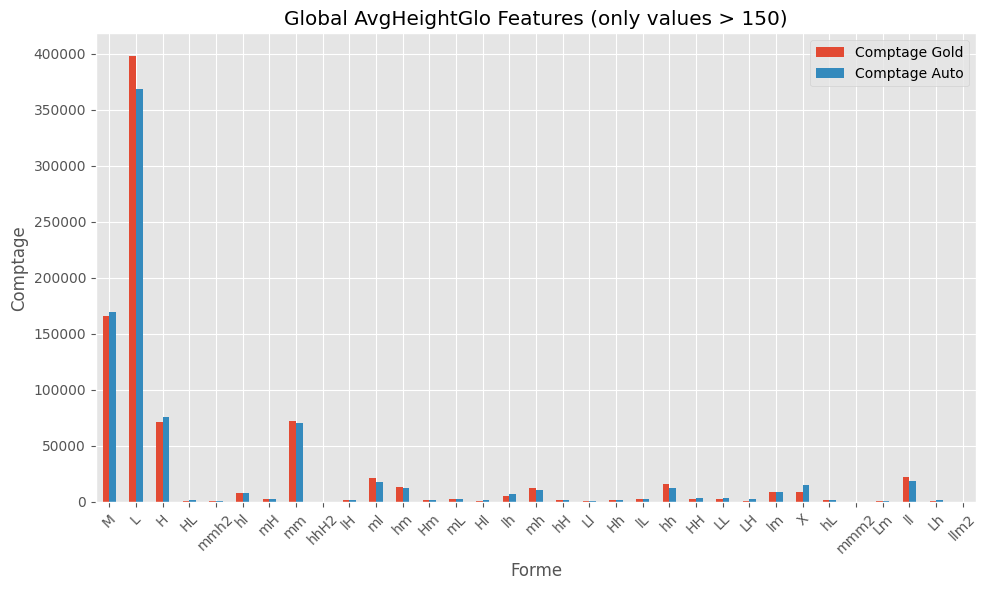

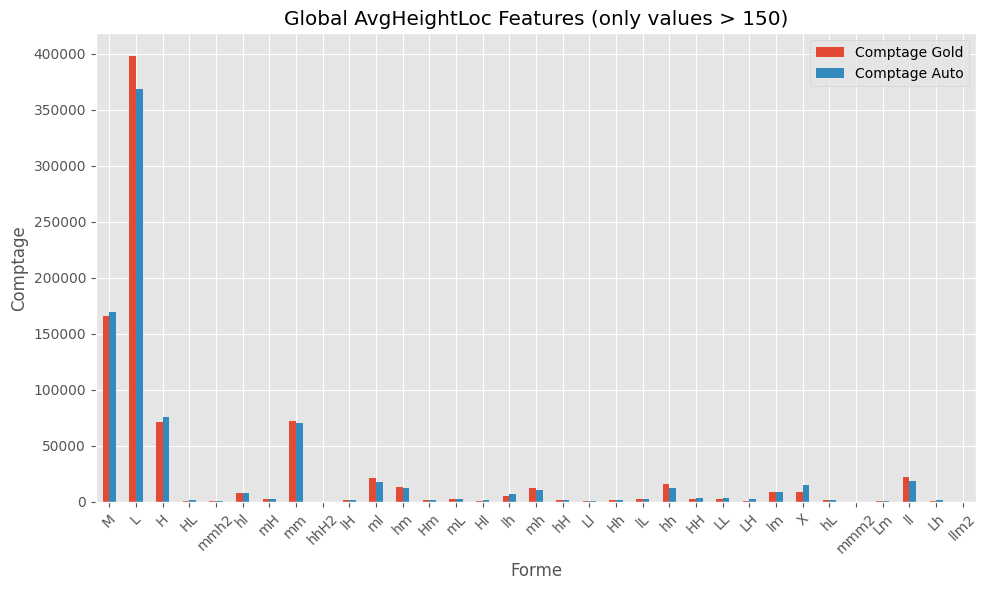

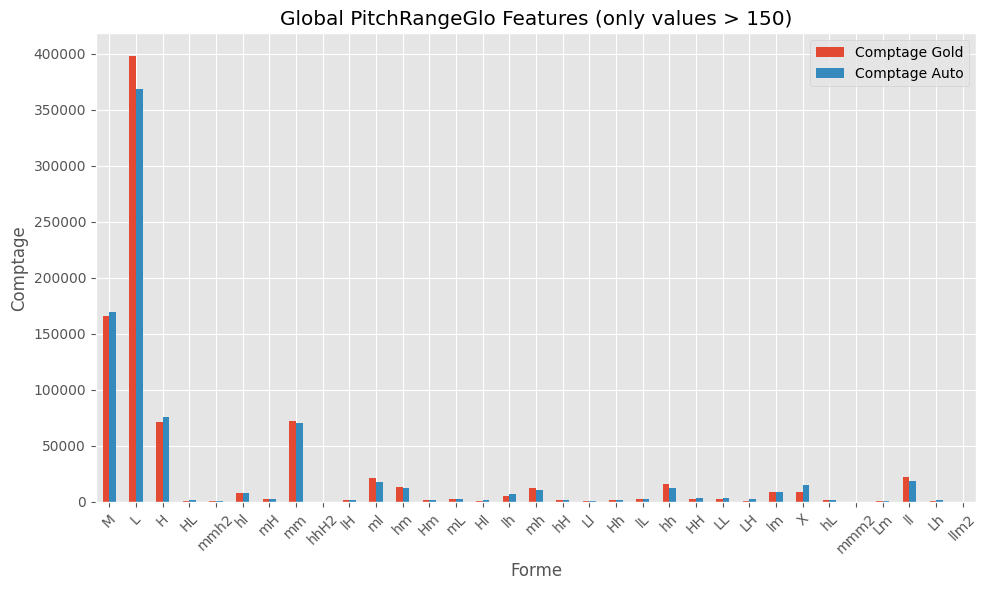

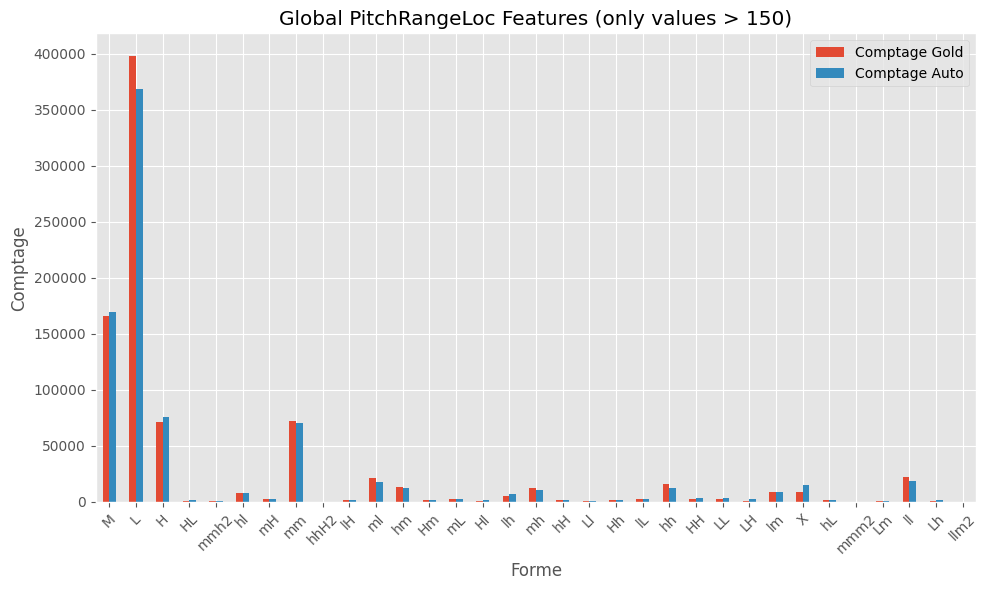

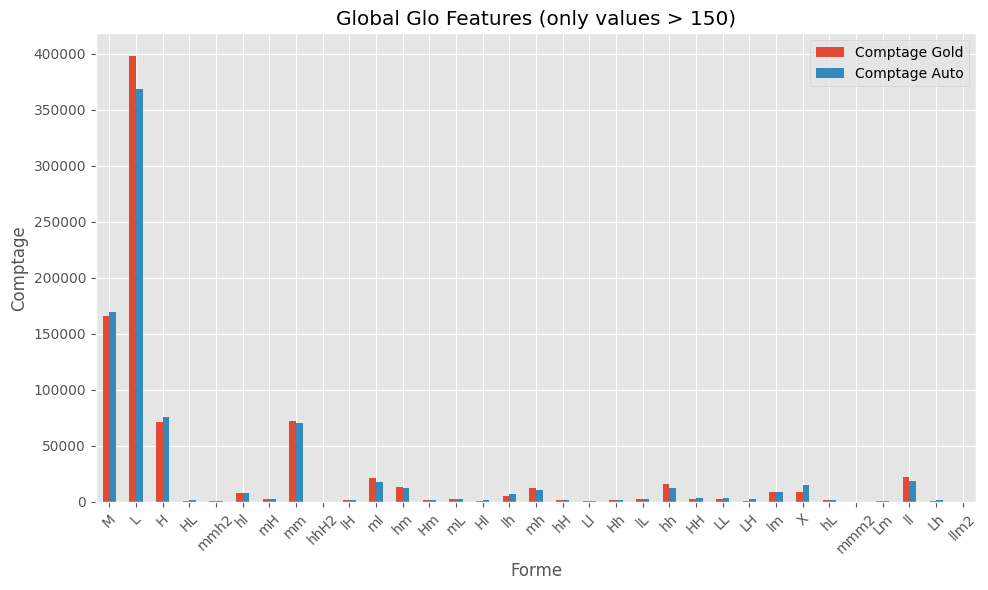

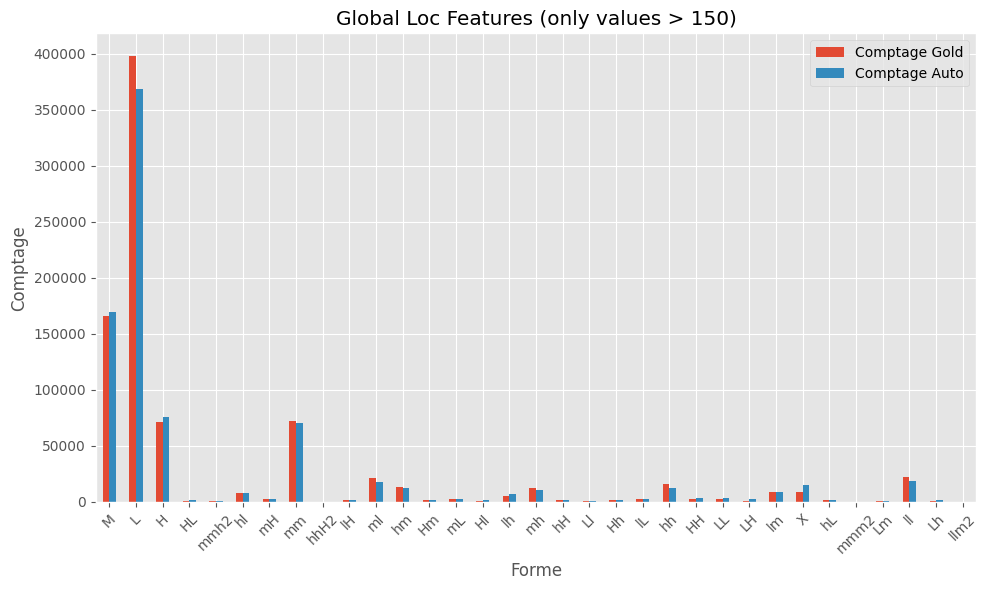

Forme,Comptage Gold,Comptage Auto
M,166237,169291
L,398116,368758
H,70969,75811
HL,517,1852
HHH2,67,123
mmh2,997,807
mLm3,6,7
LLl3,0,12
hmh3,10,23
hmh2,104,71


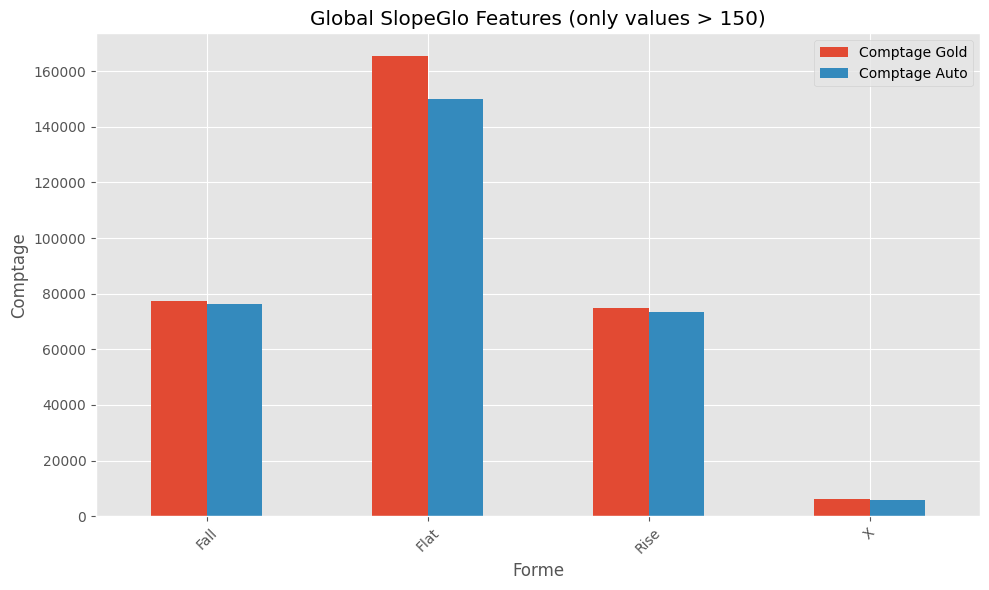

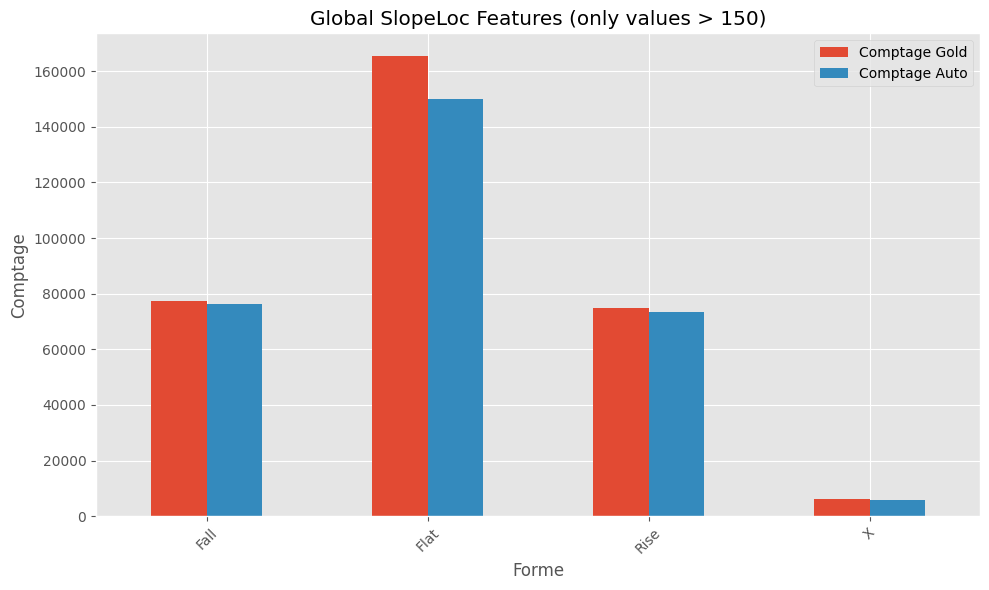

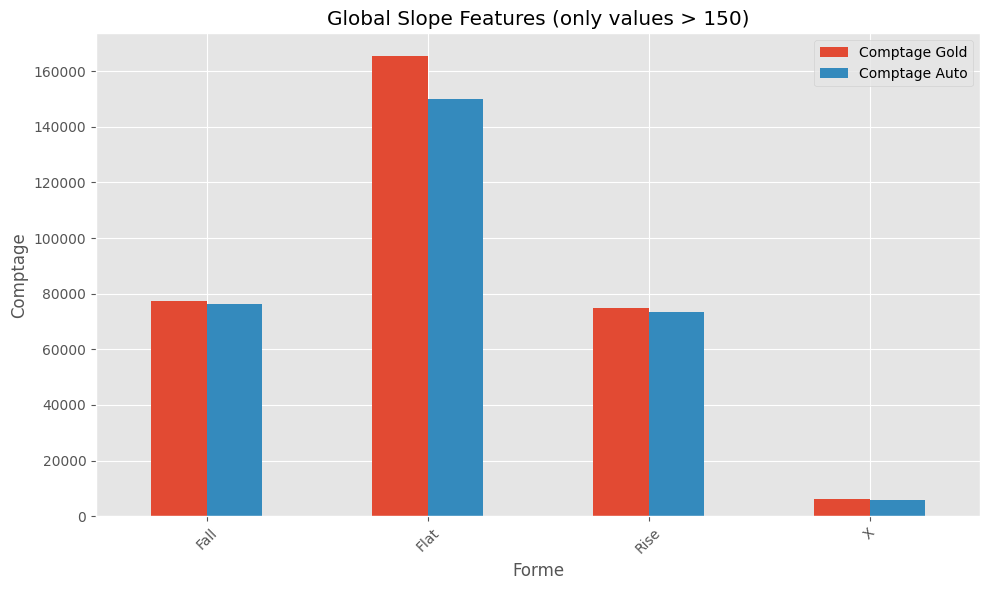

Forme,Comptage Gold,Comptage Auto
Fall,77332,76241
Flat,165337,150078
Rise,74978,73580
X,6176,5872
Forme,Comptage Gold,Comptage Auto
Fall,77332,76241
Flat,165337,150078
Rise,74978,73580
X,6176,5872
Forme,Comptage Gold,Comptage Auto


In [733]:
def main(gold_files, auto_files):
    results = []
    # Initialisation des dictionnaires pour les compteurs globaux
    counts_dicts = {
        "global_syllable_form_count": defaultdict(lambda: [0, 0]),
        "global_mono_syllable_form_count": defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0})),
        "global_external_onset_count": defaultdict(lambda: [0, 0]),
        "global_avgheightglo_count": defaultdict(lambda: [0, 0]),
        "global_avgheightloc_count": defaultdict(lambda: [0, 0]),
        "global_pitchrangeglo_count": defaultdict(lambda: [0, 0]),
        "global_pitchrangeloc_count": defaultdict(lambda: [0, 0]),
        "global_glo_count": defaultdict(lambda: [0, 0]),
        "global_loc_count": defaultdict(lambda: [0, 0]),
        "global_slopeglo_count": defaultdict(lambda: [0, 0]),
        "global_slopeloc_count": defaultdict(lambda: [0, 0]),
        "global_slope_count": defaultdict(lambda: [0, 0]),
        "global_tokens_alignment_differences": defaultdict(lambda: [0, 0]),
        "gold_duration": defaultdict(lambda: [0, 0]),
        "auto_duration": defaultdict(lambda: [0, 0]),
    }

    gold_total_syllables = 0
    auto_total_syllables = 0

    # Parcours des fichiers gold
    for gold_file in tqdm(gold_files):
        gold_sentences, gold_silence = extract_trees_and_metadata(gold_file)
        basename = os.path.basename(gold_file)
        corresponding_auto_files = [f for f in auto_files if basename in f]

        if corresponding_auto_files:
            auto_file = corresponding_auto_files[0]
            auto_sentences, auto_silence = extract_trees_and_metadata(auto_file)

            # Calcul des différents compteurs
            syllables_count = count_matching_number_syllables(gold_sentences, auto_sentences)
            syllables_form_count = count_matching_form_syllables(gold_sentences, auto_sentences)
            token_alignment_count = count_matching_token_alignment_features(gold_sentences, auto_sentences)
            slam_similarity_count = count_matching_slam_similarity(gold_sentences, auto_sentences)
            slope_similarity_count = count_matching_slope_similarity(gold_sentences, auto_sentences)
            alignment_differences = count_alignment_differences(gold_sentences, auto_sentences)

            matching_silence = count_matching_silence_alignment(gold_silence, auto_silence)
            silence_duration = count_silence_alignment_duration(gold_silence, auto_silence)

            total_tokens = syllables_count["TotalTokens"]

            # Stockage des résultats de correspondance
            matching_result_tokens = {
                'file': basename,
                'TotalTokens': total_tokens,
                'MatchingSyllableCount': format_count_and_percentage(syllables_count["MatchingSyllableCount"], calculate_percentage(syllables_count["MatchingSyllableCount"], total_tokens)),
                'MatchingFormSyllableCount': format_count_and_percentage(syllables_form_count["MatchingSyllableCount"], calculate_percentage(syllables_form_count["MatchingSyllableCount"], total_tokens)),
                'MatchingTokenAlignmentCount': format_count_and_percentage(token_alignment_count["MatchingTokenAlignmentCount"], calculate_percentage(token_alignment_count["MatchingTokenAlignmentCount"], total_tokens)),
                'MatchingAvgHeightGloCount': format_count_and_percentage(slam_similarity_count["MatchingAvgHeightGloCount"], calculate_percentage(slam_similarity_count["MatchingAvgHeightGloCount"], total_tokens)),
                'MatchingAvgHeightLocCount': format_count_and_percentage(slam_similarity_count["MatchingAvgHeightLocCount"], calculate_percentage(slam_similarity_count["MatchingAvgHeightLocCount"], total_tokens)),
                'MatchingPitchRangeGloCount': format_count_and_percentage(slam_similarity_count["MatchingPitchRangeGloCount"], calculate_percentage(slam_similarity_count["MatchingPitchRangeGloCount"], total_tokens)),
                'MatchingPitchRangeLocCount': format_count_and_percentage(slam_similarity_count["MatchingPitchRangeLocCount"], calculate_percentage(slam_similarity_count["MatchingPitchRangeLocCount"], total_tokens)),
                'MatchingGloCount': format_count_and_percentage(slam_similarity_count["MatchingGloCount"], calculate_percentage(slam_similarity_count["MatchingGloCount"], total_tokens)),
                'MatchingLocCount': format_count_and_percentage(slam_similarity_count["MatchingLocCount"], calculate_percentage(slam_similarity_count["MatchingLocCount"], total_tokens)),
                'MatchingSlopeGloCount': format_count_and_percentage(slope_similarity_count["MatchingSlopeGloCount"], calculate_percentage(slope_similarity_count["MatchingSlopeGloCount"], total_tokens)),
                'MatchingSlopeLocCount': format_count_and_percentage(slope_similarity_count["MatchingSlopeLocCount"], calculate_percentage(slope_similarity_count["MatchingSlopeLocCount"], total_tokens)),
                'MatchingSlopeCount': format_count_and_percentage(slope_similarity_count["MatchingSlopeCount"], calculate_percentage(slope_similarity_count["MatchingSlopeCount"], total_tokens)),
                'MatchingAlignmentDifferences': alignment_differences["MatchingCountsByInterval"],
                'TotalSilenceTokensGold': matching_silence["TotalSilenceTokensGold"],
                'TotalSilenceTokensAuto': matching_silence["TotalSilenceTokensAuto"],
            }

            results.append(matching_result_tokens)

            # Mise à jour des compteurs globaux pour les caractéristiques des syllabes
            syllables_features = count_syllable_features(gold_sentences, auto_sentences)
            update_global_counts(counts_dicts["global_syllable_form_count"], syllables_features[0])
            update_global_counts(counts_dicts["global_external_onset_count"], syllables_features[1])

            gold_total_syllables += syllables_features[2]
            auto_total_syllables += syllables_features[3]

            syllable_data, gold_total_syllables, auto_total_syllables = count_mono_syllable_features(gold_sentences, auto_sentences)
            update_global_counts_mono(counts_dicts["global_mono_syllable_form_count"], syllable_data)

            # Mise à jour des compteurs globaux pour les caractéristiques slam
            slam_features = slam(gold_sentences, auto_sentences)
            for df in slam_features:
                update_global_counts(counts_dicts["global_avgheightglo_count"], df)
                update_global_counts(counts_dicts["global_avgheightloc_count"], df)
                update_global_counts(counts_dicts["global_pitchrangeglo_count"], df)
                update_global_counts(counts_dicts["global_pitchrangeloc_count"], df)
                update_global_counts(counts_dicts["global_glo_count"], df)
                update_global_counts(counts_dicts["global_loc_count"], df)

            # Mise à jour des compteurs globaux pour les caractéristiques slope
            slope_features = slope(gold_sentences, auto_sentences)
            for df in slope_features:
                update_global_counts(counts_dicts["global_slopeglo_count"], df)
                update_global_counts(counts_dicts["global_slopeloc_count"], df)
                update_global_counts(counts_dicts["global_slope_count"], df)

            counts_dicts["gold_duration"] = sum_counters([counts_dicts["gold_duration"], silence_duration["GoldCountsByInterval"]])
            counts_dicts["auto_duration"] = sum_counters([counts_dicts["auto_duration"], silence_duration["AutoCountsByInterval"]])
            counts_dicts["global_tokens_alignment_differences"] = sum_counters([counts_dicts["global_tokens_alignment_differences"], alignment_differences["MatchingCountsByInterval"]])

    # Préparation des données pour les différences d'alignement des tokens
    df_tokens_difference_alignement = pd.DataFrame.from_dict(counts_dicts["global_tokens_alignment_differences"], orient='index', columns=['MatchingCountsByInterval']).reset_index()
    df_tokens_difference_alignement = df_tokens_difference_alignement.rename(columns={'index': 'IntervalDifference'})
    total_counts = df_tokens_difference_alignement['MatchingCountsByInterval'].sum()
    df_tokens_difference_alignement['Percentage'] = df_tokens_difference_alignement['MatchingCountsByInterval'] / total_counts * 100
    df_tokens_difference_alignement = df_tokens_difference_alignement.sort_values(by='IntervalDifference')

    # Tracé des graphes pour les différences d'alignement des tokens
    df_tokens_difference_alignement.plot(kind='bar', x='IntervalDifference', y='MatchingCountsByInterval', figsize=(15, 6))
    plt.xlabel('Interval Difference (ms)')
    plt.ylabel('Count')
    plt.title('Alignment Differences Between Gold and Auto Tokens')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('alignment_tokens_differences.png')
    plt.show()

    # Ajout du formatage après le tracé
    df_tokens_difference_alignement['MatchingCountsByInterval'] = df_tokens_difference_alignement.apply(lambda row: f"{row['MatchingCountsByInterval']} ({row['Percentage']:.2f}%)", axis=1)
    df_tokens_difference_alignement = df_tokens_difference_alignement.drop(columns=['Percentage'])

    # Préparation des données pour la durée du silence
    df_gold_duration = pd.DataFrame.from_dict(counts_dicts["gold_duration"], orient='index', columns=['GoldCount']).reset_index()
    df_auto_duration = pd.DataFrame.from_dict(counts_dicts["auto_duration"], orient='index', columns=['AutoCount']).reset_index()
    df_duration = pd.merge(df_gold_duration, df_auto_duration, on='index', how='outer').fillna(0)
    df_duration = df_duration.rename(columns={'index': 'Duration'})
    df_duration = df_duration.sort_values(by='Duration')

    # Sauvegarde des résultats de comparaison des durées en HTML
    silence_duration_html_filename = 'silence_duration_comparison'
    silence_duration_html = df_duration.to_html(index=False)
    with open(f'{silence_duration_html_filename}.html', 'w') as f:
        f.write(silence_duration_html)
    # pdfkit.from_file(f'{silence_duration_html_filename}.html', f'{silence_duration_html_filename}.pdf')
    display(HTML(silence_duration_html))

    # Trace des graphes pour la comparaison des durées
    df_duration.plot(kind='bar', x='Duration', y=['GoldCount', 'AutoCount'], figsize=(15, 6))
    plt.xlabel('Duration (ms)')
    plt.ylabel('Count')
    plt.title('Comparison of Gold and Auto Silence Durations')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('silence_duration_comparison.png')
    plt.show()

    # Agrégation des résultats de correspondance
    df = pd.DataFrame(results)
    aggregate_matching_results = {
        "TotalTokens": df["TotalTokens"].sum(),
        "TotalMatchingSyllableCount": df["MatchingSyllableCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingFormSyllableCount": df["MatchingFormSyllableCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingTokenAlignmentCount": df["MatchingTokenAlignmentCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingAvgHeightGloCount": df["MatchingAvgHeightGloCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingAvgHeightLocCount": df["MatchingAvgHeightLocCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingPitchRangeGloCount": df["MatchingPitchRangeGloCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingPitchRangeLocCount": df["MatchingPitchRangeLocCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingGloCount": df["MatchingGloCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingLocCount": df["MatchingLocCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingSlopeGloCount": df["MatchingSlopeGloCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingSlopeLocCount": df["MatchingSlopeLocCount"].apply(lambda x: int(x.split()[0])).sum(),
        "TotalMatchingSlopeCount": df["MatchingSlopeCount"].apply(lambda x: int(x.split()[0])).sum()
    }

    total_tokens = aggregate_matching_results["TotalTokens"]
    formatted_aggregate_results = {
        key: format_count_and_percentage(value, calculate_percentage(value, total_tokens))
        for key, value in aggregate_matching_results.items() if key != "TotalTokens"
    }
    formatted_aggregate_results["TotalTokens"] = total_tokens

    # Sauvegarde des résultats de correspondance agrégés en HTML et PDF
    aggregate_matching_df = pd.DataFrame([formatted_aggregate_results])
    aggregate_matching_html_filename = 'aggregate_matching_results'
    aggregate_matching_html = aggregate_matching_df.to_html(index=False)
    with open(f'{aggregate_matching_html_filename}.html', 'w') as f:
        f.write(aggregate_matching_html)
    pdfkit.from_file(f'{aggregate_matching_html_filename}.html', f'{aggregate_matching_html_filename}.pdf')
    display(HTML(aggregate_matching_html))

    alignment_tokens_differences_html_filename = 'alignment_tokens_differences'
    alignment_tokens_differences_html = df_tokens_difference_alignement.to_html(index=False)
    with open(f'{alignment_tokens_differences_html_filename}.html', 'w') as f:
        f.write(alignment_tokens_differences_html)
    pdfkit.from_file(f'{alignment_tokens_differences_html_filename}.html', f'{alignment_tokens_differences_html_filename}.pdf')
    display(HTML(alignment_tokens_differences_html))

    # Conversion des dictionnaires en DataFrames pour chaque type de feature
    df_global_syllable_form = convert_dict_to_df(counts_dicts["global_syllable_form_count"])
    df_global_mono_syllable_form = convert_monosyllableform_defaultdict_to_df(counts_dicts["global_mono_syllable_form_count"])
    df_global_external_onset = convert_dict_to_df(counts_dicts["global_external_onset_count"])
    df_global_avgheightglo = convert_dict_to_df(counts_dicts["global_avgheightglo_count"])
    df_global_avgheightloc = convert_dict_to_df(counts_dicts["global_avgheightloc_count"])
    df_global_pitchrangeglo = convert_dict_to_df(counts_dicts["global_pitchrangeglo_count"])
    df_global_pitchrangeloc = convert_dict_to_df(counts_dicts["global_pitchrangeloc_count"])
    df_global_glo = convert_dict_to_df(counts_dicts["global_glo_count"])
    df_global_loc = convert_dict_to_df(counts_dicts["global_loc_count"])
    df_global_slopeglo = convert_dict_to_df(counts_dicts["global_slopeglo_count"])
    df_global_slopeloc = convert_dict_to_df(counts_dicts["global_slopeloc_count"])
    df_global_slope = convert_dict_to_df(counts_dicts["global_slope_count"])

    # Sauvegarde des features en HTML et PDF
    plot_features(df_global_syllable_form, 'Global Syllable Form', 30)
    plot_features(df_global_external_onset, 'Global External Onset', 5)
    save_html([df_global_syllable_form, df_global_external_onset], 
              ["Global Syllable Form Features:", "Global External Onset Features:"], 
              'aggregate_syllables_features')
    
    save_html([df_global_mono_syllable_form], ["Global Mono Syllable Form Features:"], 'aggregate_mono_syllables_features')

    # Creating DataFrame from global mono syllable form data
    mono_syllable_data = []
    for token, forms in counts_dicts["global_mono_syllable_form_count"].items():
        for form, counts in forms.items():
            mono_syllable_data.append([token, form, counts['Gold'], counts['Auto']])
    
    df_mono_syllable_form = pd.DataFrame(mono_syllable_data, columns=['Token', 'Form', 'Gold Count', 'Auto Count'])

    # Grouping by token and calculating the most frequent form for Gold and Auto
    most_frequent_gold = df_mono_syllable_form.groupby('Token').apply(lambda x: x.loc[x['Gold Count'].idxmax()])
    most_frequent_auto = df_mono_syllable_form.groupby('Token').apply(lambda x: x.loc[x['Auto Count'].idxmax()])

    # Creating a new DataFrame for the result
    result = pd.DataFrame({
        "Token": most_frequent_gold['Token'],
        "Form Gold": most_frequent_gold['Form'],
        "Form Gold Count Gold": most_frequent_gold['Gold Count'],
        "Form Gold Count Auto": most_frequent_gold['Auto Count'],
        "Form Auto": most_frequent_auto['Form'],
        "Form Auto Count Gold": most_frequent_auto['Gold Count'],
        "Form Auto Count Auto": most_frequent_auto['Auto Count']
    })

    result.reset_index(drop=True, inplace=True)
    save_html([result], ["Global Mono Syllable Form Frequency:"], 'aggregate_mono_syllables_frequency')
    
    plot_features(df_global_avgheightglo, 'Global AvgHeightGlo')
    plot_features(df_global_avgheightloc, 'Global AvgHeightLoc')
    plot_features(df_global_pitchrangeglo, 'Global PitchRangeGlo')
    plot_features(df_global_pitchrangeloc, 'Global PitchRangeLoc')
    plot_features(df_global_glo, 'Global Glo')
    plot_features(df_global_loc, 'Global Loc')
    save_html([df_global_avgheightglo, df_global_avgheightloc, df_global_pitchrangeglo, df_global_pitchrangeloc, df_global_glo, df_global_loc], 
              ["Global AvgHeightGlo Features", "Global AvgHeightLoc Features", "Global PitchRangeGlo Features", "Global PitchRangeLoc Features", "Global Glo Features", "Global Loc Features"], 
              'aggregate_slam_features')
    
    plot_features(df_global_slopeglo, 'Global SlopeGlo')
    plot_features(df_global_slopeloc, 'Global SlopeLoc')
    plot_features(df_global_slope, 'Global Slope')
    save_html([df_global_slopeglo, df_global_slopeloc, df_global_slope], 
              ["Global SlopeGlo Features:", "Global SlopeLoc Features:", "Global Slope Features:"], 
              'aggregate_slope_features')
    

# Appel de la fonction principale
main(conll_infiles, conll_outfolder)